### Importing Libraries

In [ ]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor,ToPILImage
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
#Importing the libraries
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import GlobalAveragePooling2D, Input, Flatten
from keras import optimizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
import keras


### Loading the data

In [ ]:
#Loading data
cifar_10=tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 3s 0us/step


### Data Exploration

In [ ]:
print(type(cifar_10))
print(len(cifar_10))
print(type(cifar_10[0][0]))
print(cifar_10[0][0].shape)
print(cifar_10[1][0].shape)
#Cifar10 data consists of 2 image cohorts. One for training (50000 images) and the other for testing (10000 images)
# These images are 32 x 32 sq.pixel resolution color images (varying RGB)

<class 'tuple'>
2
<class 'numpy.ndarray'>
(50000, 32, 32, 3)
(10000, 32, 32, 3)


AxesImage(54,36;334.8x217.44)


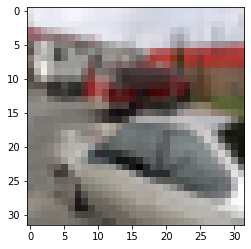

In [ ]:
#Displaying sample images
print(plt.imshow(cifar_10[0][0][49999]))

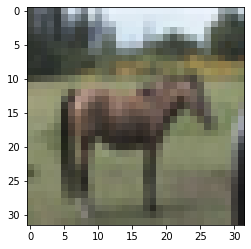

In [ ]:
#Displaying sample images
plt.imshow(cifar_10[1][0][9999])

In [ ]:
#Cifar-10 has images each belonging to 10 classes
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck']
(x_train, y_train), (x_test, y_test) = cifar_10
#Seperating the labels from images to enable easy modelling and validation
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


frog


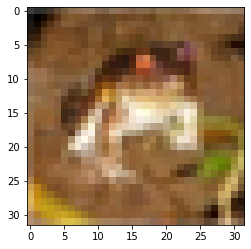

In [ ]:
#Sample image
plt.imshow(x_train[0,0:])
print(class_names[y_train[0][0]])

<BarContainer object of 10 artists>

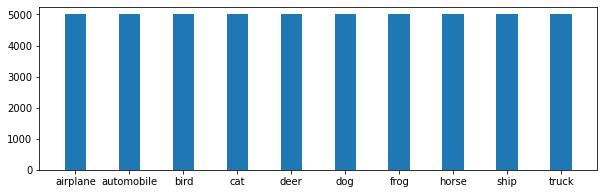

In [ ]:
classes, counts = np.unique(y_train, return_counts=True)
plt_1 = plt.figure(figsize=(10, 3))
plt.bar(class_names, counts,width = 0.4,label=True)
# Distribution of images in the classes are same for train data (5000 images across 10 sets)

<BarContainer object of 10 artists>

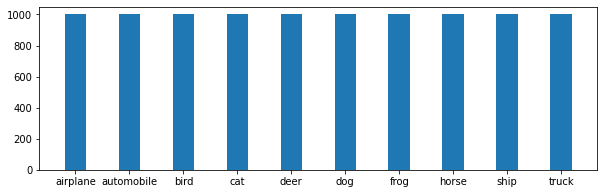

In [ ]:
classes, counts = np.unique(y_test, return_counts=True)
plt_1 = plt.figure(figsize=(10, 3))
plt.bar(class_names, counts,width = 0.4,label=True)
# Distribution of images in the classes are same for test data (1000 images across 10 sets)

### Data Pre Processing

In [ ]:
#Converting the integer labels to one-hot encoded format
#This makes labels compatible with the model, and also provides an efficient way to represent the categorical data
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)
#Example
print(y_train[1])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [ ]:
#Performance optimization settings
at = tf.data.AUTOTUNE
#Batch size is an important hyperparameter that can affect the model's performance and training time
batch_len = 32
#It is used to resize the images to the same fixed size that can influence model's performance
img_size = 32

In [ ]:
print(y_train[1])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [ ]:
def preprocess_image(image, label):
   #By resizing, the model is able to process all the images consistently and not be affected by the original size of the images. 
    image = tf.image.resize(image, (img_size, img_size))
    #Normalizing image pixel values to a small range(0,1) improves training stability.
    image = tf.image.convert_image_dtype(image, tf.float32) / 255.0
    return image, label

#### Creating TensorFlow data objects
#####  The following code snippet sets up the data pipeline by loading, shuffling, preprocessing, and batching the training and testing data and also creating a dataset by combining two shuffled datasets from the same training data. 
##### These operations help to improve the model's performance and make the data pipeline more efficient and easy to use with TensorFlow.These operations help to improve the model's performance and make the data pipeline more efficient and easy to use with TensorFlow.





In [ ]:
#train_ds_a & train_ds_b are created by shuffling the training data (x_train, y_train) and applying the preprocess_image function to each example. 
#Shuffling the data is important to improve the model's generalization.
train_ds_a_shuffle = (tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(1024))
train_ds_a=train_ds_a_shuffle.map(preprocess_image, num_parallel_calls=at)

train_ds_b_shuffle = (tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(1024))
train_ds_b=train_ds_b_shuffle.map(preprocess_image, num_parallel_calls=at)

#Loading (x_train, y_train) into a TensorFlow Dataset object.
train_ds_simple = tf.data.Dataset.from_tensor_slices((x_train, y_train))

#Loading(x_test, y_test) into a TensorFlow Dataset object.
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

#prefetch() is a method in TensorFlow Dataset that allows the pipeline to asynchronously fetch the next batch of data, while the current batch is being processed. 
train_ds_simple = (  
    train_ds_simple.map(preprocess_image, num_parallel_calls=at)
    .batch(batch_len)
    .prefetch(at)
)

# Combine two shuffled datasets from the same training data.
train_ds = tf.data.Dataset.zip((train_ds_a, train_ds_b))
test_ds = (test_ds.map(preprocess_image, num_parallel_calls=at).batch(batch_len)
    .prefetch(at))

In [ ]:
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


@tf.function
def get_box(lambda_value):
    cut_rat = tf.math.sqrt(1.0 - lambda_value)

    cut_w = img_size * cut_rat  # rw
    cut_w = tf.cast(cut_w, tf.int32)

    cut_h = img_size * cut_rat  # rh
    cut_h = tf.cast(cut_h, tf.int32)

    cut_x = tf.random.uniform((1,), minval=0, maxval=img_size, dtype=tf.int32)  # rx
    cut_y = tf.random.uniform((1,), minval=0, maxval=img_size, dtype=tf.int32)  # ry

    boundaryx1 = tf.clip_by_value(cut_x[0] - cut_w // 2, 0, img_size)
    boundaryy1 = tf.clip_by_value(cut_y[0] - cut_h // 2, 0, img_size)
    bbx2 = tf.clip_by_value(cut_x[0] + cut_w // 2, 0, img_size)
    bby2 = tf.clip_by_value(cut_y[0] + cut_h // 2, 0, img_size)

    target_h = bby2 - boundaryy1
    if target_h == 0:
        target_h += 1

    target_w = bbx2 - boundaryx1
    if target_w == 0:
        target_w += 1

    return boundaryx1, boundaryy1, target_h, target_w


@tf.function
def cutmix(train_ds_a, train_ds_b):
    (image1, label1), (image2, label2) = train_ds_a, train_ds_b

    alpha = [0.25]
    beta = [0.25]

    # Get a sample from the Beta distribution
    lambda_value = sample_beta_distribution(1, alpha, beta)

    # Define Lambda
    lambda_value = lambda_value[0][0]

    # Get the bounding box offsets, heights and widths
    boundaryx1, boundaryy1, target_h, target_w = get_box(lambda_value)

    # Get a patch from the second image (`image2`)
    crop2 = tf.image.crop_to_bounding_box(
        image2, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image2` patch (`crop2`) with the same offset
    image2 = tf.image.pad_to_bounding_box(
        crop2, boundaryy1, boundaryx1, img_size, img_size
    )
    # Get a patch from the first image (`image1`)
    crop1 = tf.image.crop_to_bounding_box(
        image1, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image1` patch (`crop1`) with the same offset
    img1 = tf.image.pad_to_bounding_box(
        crop1, boundaryy1, boundaryx1, img_size, img_size
    )

    # Modify the first image by subtracting the patch from `image1`
    # (before applying the `image2` patch)
    image1 = image1 - img1
    # Add the modified `image1` and `image2`  together to get the CutMix image
    image = image1 + image2

    # Adjust Lambda in accordance to the pixel ration
    lambda_value = 1 - (target_w * target_h) / (img_size * img_size)
    lambda_value = tf.cast(lambda_value, tf.float64)
    label1 = tf.cast(label1, tf.float64)
    label2 = tf.cast(label2, tf.float64)
    # Combine the labels of both images
    label = lambda_value * label1 + (1 - lambda_value) * label2
    return image, label

### Cutmix Data Aumgentation


<PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float64, name=None))>


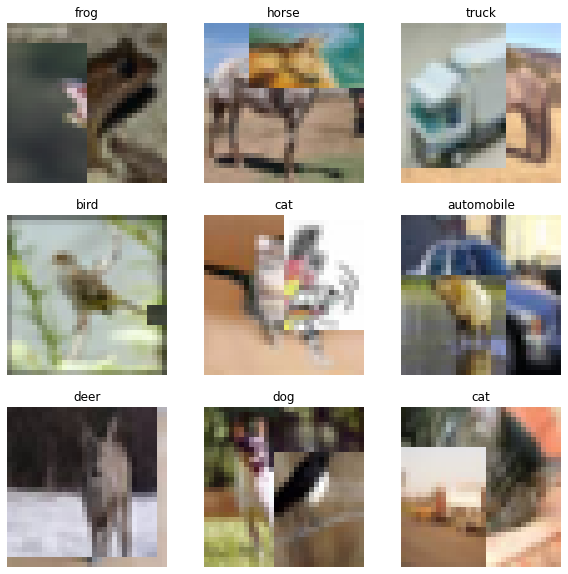

In [ ]:
# Create the new dataset using our `cutmix` utility
train_ds_cmu = (train_ds.shuffle(1024)
    .map(cutmix, num_parallel_calls=at)
    .batch(batch_len)
    .prefetch(at)
)
print(train_ds_cmu)
# Let's preview 9 samples from the dataset
image_batch, label_batch = next(iter(train_ds_cmu))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(class_names[np.argmax(label_batch[i])])
    plt.imshow(image_batch[i])
    plt.axis("off")

1563

In [ ]:
eirbfeibfiebrf

In [ ]:
def resnet_layer(
    inputs,
    num_filters=16,
    kernel_size=3,
    strides=1,
    activation="relu",
    batch_normalization=True,
    conv_first=True,
):
    conv = keras.layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        strides=strides,
        padding="same",
        kernel_initializer="he_normal",
        kernel_regularizer=keras.regularizers.l2(1e-4),
    )
    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = keras.layers.BatchNormalization()(x)
        if activation is not None:
            x = keras.layers.Activation(activation)(x)
    else:
        if batch_normalization:
            x = keras.layers.BatchNormalization()(x)
        if activation is not None:
            x = keras.layers.Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v20(input_shape, depth, num_classes=10):
    if (depth - 2) % 6 != 0:
        raise ValueError("depth should be 6n+2 (eg 20, 32, 44 in [a])")
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = keras.layers.Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x, num_filters=num_filters, strides=strides)
            y = resnet_layer(inputs=y, num_filters=num_filters, activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(
                    inputs=x,
                    num_filters=num_filters,
                    kernel_size=1,
                    strides=strides,
                    activation=None,
                    batch_normalization=False,
                )
            x = keras.layers.add([x, y])
            x = keras.layers.Activation("relu")(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = keras.layers.AveragePooling2D(pool_size=8)(x)
    y = keras.layers.Flatten()(x)
    outputs = keras.layers.Dense(
        num_classes, activation="softmax", kernel_initializer="he_normal"
    )(y)

    # Instantiate model.
    model = keras.models.Model(inputs=inputs, outputs=outputs)
    return model


def training_model():
    return resnet_v20((32, 32, 3), 20)


initial_model = training_model()
initial_model.save_weights("initial_weights.h5")

In [ ]:
model = training_model()
model.load_weights("initial_weights.h5")
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(train_ds_simple, validation_data=test_ds, epochs=15)

test_loss, test_accuracy = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_accuracy * 100))

Epoch 1/15
1563/1563 [==============================] - 475s 302ms/step - loss: 1.4990 - accuracy: 0.5138 - val_loss: 1.3038 - val_accuracy: 0.5878
Epoch 2/15
1563/1563 [==============================] - 475s 304ms/step - loss: 1.0849 - accuracy: 0.6717 - val_loss: 1.1980 - val_accuracy: 0.6421
Epoch 3/15
1563/1563 [==============================] - 476s 304ms/step - loss: 0.9065 - accuracy: 0.7408 - val_loss: 1.1235 - val_accuracy: 0.6777
Epoch 4/15
1563/1563 [==============================] - 465s 297ms/step - loss: 0.8007 - accuracy: 0.7814 - val_loss: 1.2011 - val_accuracy: 0.6681
Epoch 5/15
1563/1563 [==============================] - 467s 298ms/step - loss: 0.7259 - accuracy: 0.8120 - val_loss: 1.1104 - val_accuracy: 0.7021
Epoch 6/15
1563/1563 [==============================] - 481s 308ms/step - loss: 0.6683 - accuracy: 0.8335 - val_loss: 1.3723 - val_accuracy: 0.6717
Epoch 7/15
1563/1563 [==============================] - 482s 309ms/step - loss: 0.6200 - accuracy: 0.8565 - val_

In [ ]:
print(test_loss, test_accuracy)

1.564853549003601 0.7200000286102295


In [ ]:
train_ds_cmu]

TypeError: ignored